This notebook has taken as a reference the work done by Dimitre Oliveira, so first I would like to thank him for the effort done in sharing his work with the community. His notebook is the following:
https://www.kaggle.com/code/dimitreoliveira/model-stacking-feature-engineering-and-eda

In [ ]:
!pip install catboost

In [ ]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

## Loading Data from File Folder

In [ ]:
test = pd.read_csv('input/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})

item_categories = pd.read_csv('input/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})

items = pd.read_csv('input/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})

shops = pd.read_csv('input/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})

sales_train = pd.read_csv('input/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

**Data fields**
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month nº, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

In [ ]:
len(item_categories["item_category_id"].unique())

84

In [ ]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
len(items["item_id"].unique())

22170

In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
len(shops["shop_id"].unique())

60

In [ ]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
train = sales_train.join(items, on='item_id', rsuffix='_').join(shops, on="shop_id", rsuffix='_').join(item_categories, on="item_category_id", rsuffix='_')

In [ ]:
train = train.drop(['item_id_', 'shop_id_', 'item_category_id_', "item_name", "shop_name", "item_category_name"], axis=1)

In [ ]:
print("Train rows", train.shape[0])
print("Train columns", train.shape[1])

Train rows 2935849
Train columns 7


In [ ]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_category_id,37,58,58,58,56


## Data Leakages

In [ ]:
# We only process shops and items which actually are available in test dataset
test_shops_ids = test["shop_id"].unique()
test_item_ids = test["item_id"].unique()

dlk_train = train[train["shop_id"].isin(test_shops_ids)]
dlk_train = dlk_train[dlk_train["item_id"].isin(test_item_ids)]

In [ ]:
print("DataSet before Data Leakages", train.shape[0])
print("DataSet after Data Leakages", dlk_train.shape[0])

DataSet before Data Leakages 2935849
DataSet after Data Leakages 1224439


## Pre-Processing

In [ ]:
dlk_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,1224439.00,1224439.00,1224439.00,1224439.00,1224439.00,1224439.00
mean,19.35,32.15,9614.87,1030.12,1.32,40.56
std,9.11,16.47,6299.87,1827.71,3.31,18.61
min,0.00,2.00,30.00,0.50,-16.00,2.00
25%,12.00,19.00,4181.00,299.00,1.00,25.00
50%,21.00,31.00,7856.00,549.00,1.00,38.00
75%,27.00,46.00,15229.00,1199.00,1.00,55.00
max,33.00,59.00,22167.00,59200.00,2169.00,83.00


**We will group the data by months**

In [ ]:
train_monthly = dlk_train[["date","date_block_num", "shop_id", "item_category_id", "item_id", "item_price", "item_cnt_day"]]
train_monthly = train_monthly.sort_values('date').groupby(["date_block_num", "shop_id", "item_category_id", "item_id" ], as_index=False)
train_monthly = train_monthly.agg({"item_price":["sum","mean"], "item_cnt_day":["sum","mean", "count"]})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'num_transactions']


In [ ]:
train_monthly.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,num_transactions
0,0,2,2,5572,10730.00,1532.86,9,1.29,7
1,0,2,2,5643,4775.21,2387.60,0,0.00,2
2,0,2,5,5583,1188.30,594.15,2,1.00,2
3,0,2,6,7893,5970.00,1990.00,3,1.00,3
4,0,2,6,7894,1490.00,1490.00,1,1.00,1


**For each month we need to recreate missing values for each shop and item**

In [ ]:
num_months = train_monthly["date_block_num"].unique()
shop_ids = train_monthly["shop_id"].unique()
item_ids = train_monthly["item_id"].unique()
empty_df = []

In [ ]:
for month in num_months:
    for shop_aux in shop_ids:
        for item_aux in item_ids:
            empty_df.append([month, shop_aux, item_aux])

In [ ]:
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [ ]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')

In [ ]:
### We can  replace category_id with real value via ITEM dataframe
auxiliar = []
for index, values in items["item_id"].items():
    auxiliar.append([values, items.iloc[index][2]])

In [ ]:
train_monthly['item_category_id'] = train_monthly['item_id'].apply(lambda x: auxiliar[x][1])

In [ ]:
train_monthly.fillna(0, inplace=True)

In [ ]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12) + 1)

In [ ]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.00,16.50,9.81,0.00,8.00,16.50,25.00,33.00
shop_id,6734448.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,6734448.00,11041.89,6210.74,30.00,5385.25,11265.50,16068.25,22167.00
item_category_id,6734448.00,46.22,16.69,2.00,37.00,43.00,58.00,83.00
item_price,6734448.00,187.35,2171.80,0.00,0.00,0.00,0.00,515573.59
mean_item_price,6734448.00,81.13,531.16,0.00,0.00,0.00,0.00,42990.00
item_cnt,6734448.00,0.24,3.46,-4.00,0.00,0.00,0.00,2253.00
mean_item_cnt,6734448.00,0.10,0.61,-2.00,0.00,0.00,0.00,1000.00
num_transactions,6734448.00,0.18,0.90,0.00,0.00,0.00,0.00,31.00
year,6734448.00,2013.94,0.80,2013.00,2013.00,2014.00,2015.00,2015.00


## EDA

In [ ]:
# Grouping the data for EDA
gp_month_mean = train_monthly.groupby(["month"], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(["month"], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(["shop_id"], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(["shop_id"], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(["item_category_id"], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(["item_category_id"], as_index=False)['item_cnt'].sum()

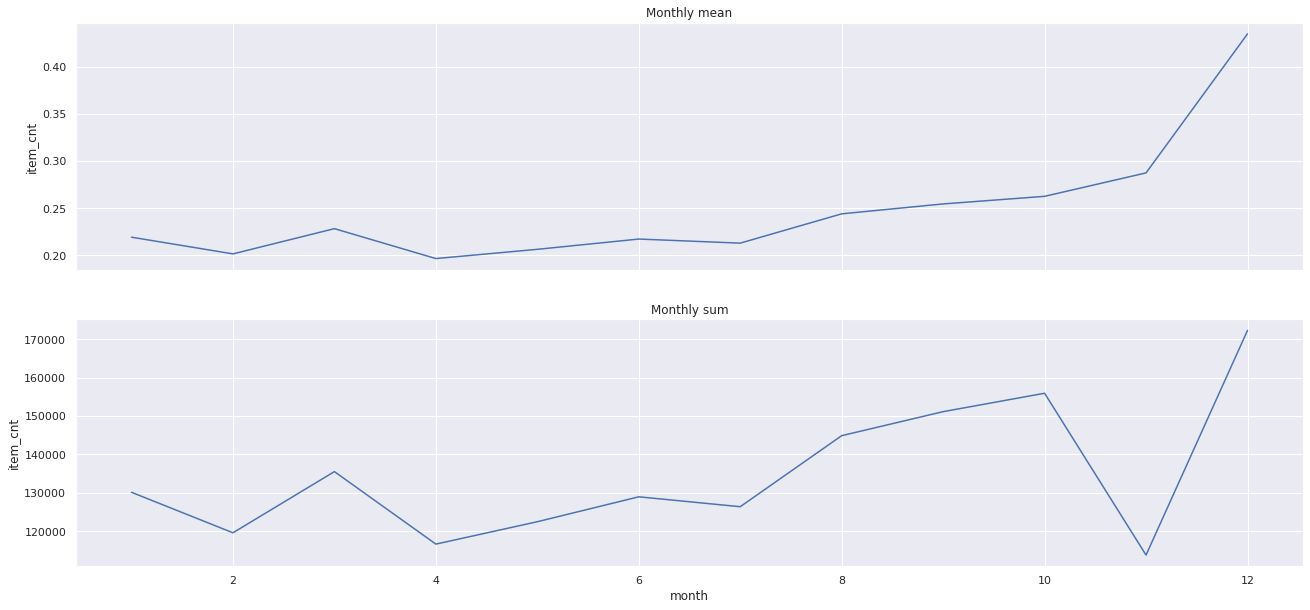

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

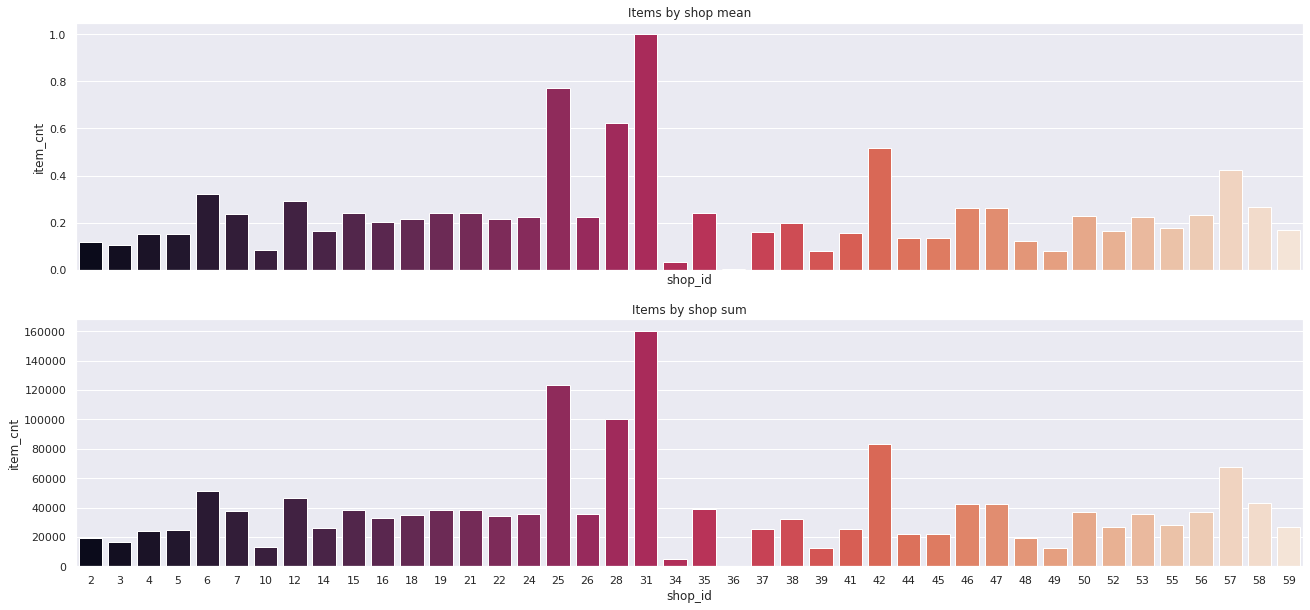

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Items by shop mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Items by shop sum")
plt.show()

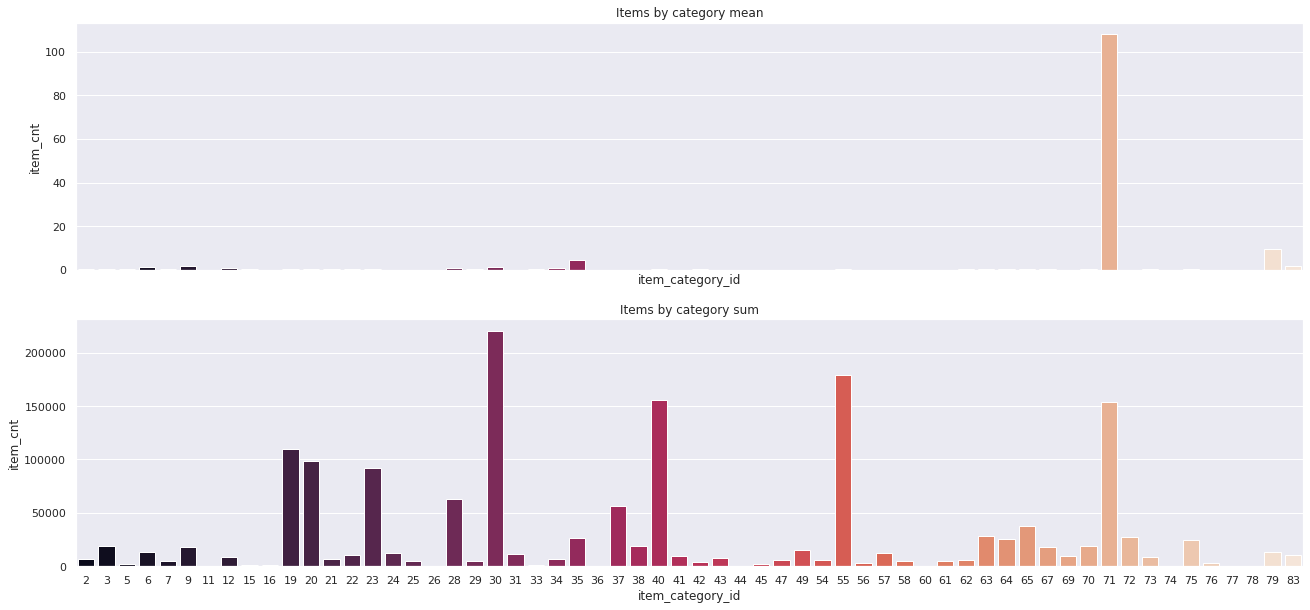

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Items by category mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Items by category sum")
plt.show()

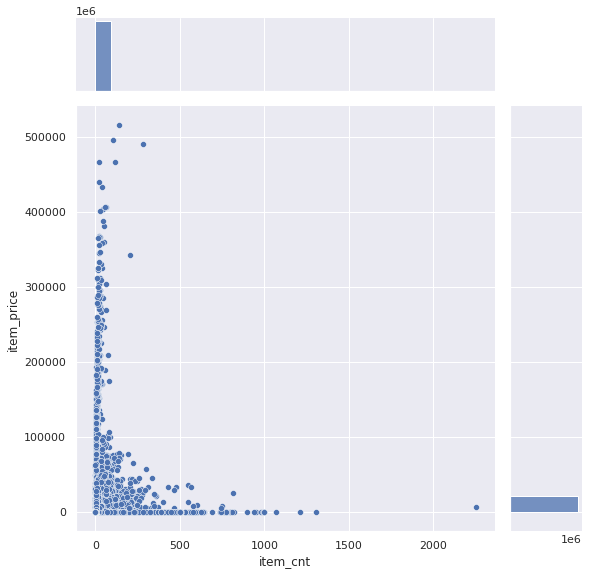

In [ ]:
# Outliers
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

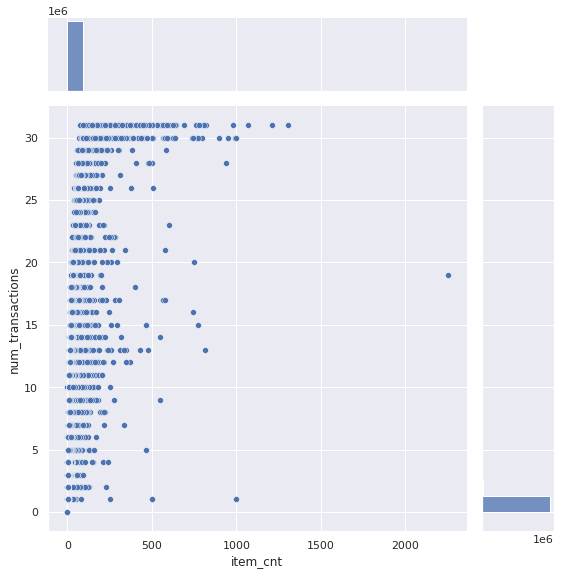

In [ ]:
sns.jointplot(x="item_cnt", y="num_transactions", data=train_monthly, height=8)
plt.show()

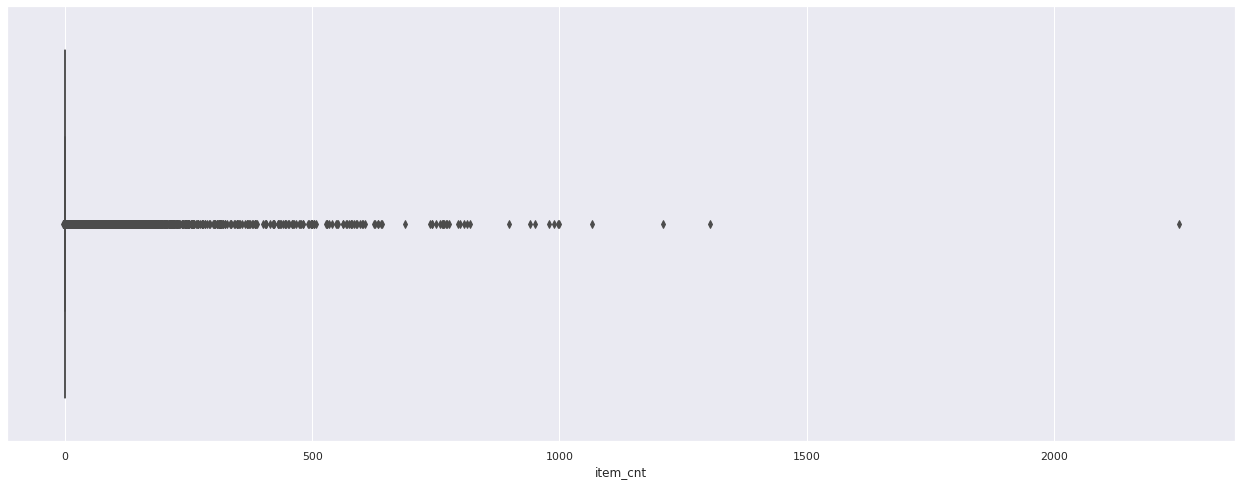

In [ ]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

In [ ]:
train_monthly = train_monthly.query('item_price < 400000')

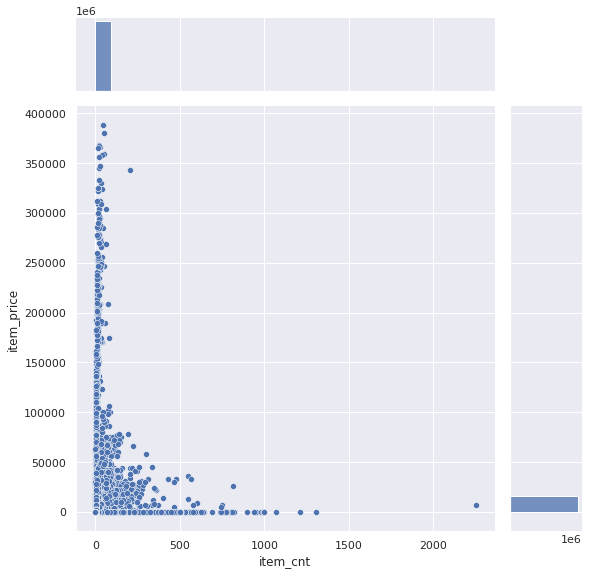

In [ ]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

In [ ]:
Q1_Y = train_monthly["item_cnt"].quantile(0.25)


In [ ]:
Q3_Y = train_monthly["item_cnt"].quantile(0.75)

In [ ]:
mean = train_monthly["item_cnt"].mean()
std = train_monthly["item_cnt"].std()
print('mean of the dataset is', mean)
print('std. deviation is', std)


mean of the dataset is 0.24008703325905342
std. deviation is 3.4537685156430697


In [ ]:
threshold = 5
outlier = []
for index, values in train_monthly["item_cnt"].items():
    z = (values-mean)/std
    if z > threshold:
        outlier.append(values)

In [ ]:
len(outlier)

7728

In [ ]:
train_monthly["item_cnt"]

0         9.00
1         0.00
2         2.00
3         3.00
4         1.00
          ... 
6734443   0.00
6734444   0.00
6734445   0.00
6734446   0.00
6734447   0.00
Name: item_cnt, Length: 6734437, dtype: float64

In [ ]:
min(outlier)

18.0

In [ ]:
max(outlier)

2253.0

In [ ]:
# We will remove all data lower than 0 and higher than 18
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 18')

In [ ]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6727085.00,16.50,9.81,0.00,8.00,16.00,25.00,33.00
shop_id,6727085.00,31.64,17.56,2.00,16.00,35.00,47.00,59.00
item_id,6727085.00,11043.33,6209.65,30.00,5386.00,11266.00,16068.00,22167.00
item_category_id,6727085.00,46.23,16.69,2.00,37.00,43.00,58.00,83.00
item_price,6727085.00,167.02,1727.64,0.00,0.00,0.00,0.00,364860.00
mean_item_price,6727085.00,79.48,520.97,0.00,0.00,0.00,0.00,42990.00
item_cnt,6727085.00,0.18,0.88,0.00,0.00,0.00,0.00,18.00
mean_item_cnt,6727085.00,0.09,0.31,0.00,0.00,0.00,0.00,18.00
num_transactions,6727085.00,0.17,0.73,0.00,0.00,0.00,0.00,18.00
year,6727085.00,2013.94,0.80,2013.00,2013.00,2014.00,2015.00,2015.00


## Feature Engineering

In [ ]:
# Forecasting problem
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [ ]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6727085.00,16.50,9.81,0.00,8.00,16.00,25.00,33.00
shop_id,6727085.00,31.64,17.56,2.00,16.00,35.00,47.00,59.00
item_id,6727085.00,11043.33,6209.65,30.00,5386.00,11266.00,16068.00,22167.00
item_category_id,6727085.00,46.23,16.69,2.00,37.00,43.00,58.00,83.00
item_price,6727085.00,167.02,1727.64,0.00,0.00,0.00,0.00,364860.00
mean_item_price,6727085.00,79.48,520.97,0.00,0.00,0.00,0.00,42990.00
item_cnt,6727085.00,0.18,0.88,0.00,0.00,0.00,0.00,18.00
mean_item_cnt,6727085.00,0.09,0.31,0.00,0.00,0.00,0.00,18.00
num_transactions,6727085.00,0.17,0.73,0.00,0.00,0.00,0.00,18.00
year,6727085.00,2013.94,0.80,2013.00,2013.00,2014.00,2015.00,2015.00


In [ ]:
# Price by unit and minimum/maximum prices
train_monthly["item_price_unit"] = train_monthly["item_price"] / train_monthly["item_cnt"]
train_monthly["item_price_unit"].replace([np.inf, -np.inf], np.nan, inplace=True)
train_monthly["item_price_unit"].fillna(0, inplace=True)

gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']
train_monthly = pd.merge(train_monthly, gp_item_price, on="item_id", how="left")

In [ ]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,10730.00,4775.21,1188.30,5970.00,1490.00
mean_item_price,1532.86,2387.60,594.15,1990.00,1490.00
item_cnt,9.00,0.00,2.00,3.00,1.00
mean_item_cnt,1.29,0.00,1.00,1.00,1.00
num_transactions,7.00,2.00,2.00,3.00,1.00
year,2013.00,2013.00,2013.00,2013.00,2013.00


In [ ]:
# How much each item's price changed from its (lowest/highest) historical price

train_monthly["price_increase"] = train_monthly["item_price"] - train_monthly["hist_min_item_price"]
train_monthly["price_decrease"] = train_monthly["hist_max_item_price"] - train_monthly["item_price"]

In [ ]:
def f_min(x):
    y = x.rolling(window=3, min_periods=1).min()
    return y

In [ ]:
def f_max(x):
    y = x.rolling(window=3, min_periods=1).max()
    return y

In [ ]:
def f_mean(x):
    y = x.rolling(window=3, min_periods=1).mean()
    return y

In [ ]:
def f_std(x):
    y = x.rolling(window=3, min_periods=1).std()
    return y

In [ ]:
function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

In [ ]:
for i in range(len(function_list)):
    train_monthly[("item_cnt_%s" % function_name[i])] = train_monthly.sort_values("date_block_num").groupby(["shop_id","item_category_id","item_id"])["item_cnt"].apply(function_list[i])

In [ ]:
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [ ]:
# Lag based features

lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ("item_cnt_shift%s" % lag)
    train_monthly[ft_name] = train_monthly.sort_values("date_block_num").groupby(["shop_id","item_category_id","item_id"])["item_cnt"].shift(lag)
    train_monthly[ft_name].fillna(0, inplace=True)
    

In [ ]:
# Trend items count

train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ("item_cnt_shift%s" % lag)
    train_monthly['item_trend'] += train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

In [ ]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,10730.00,4775.21,1188.30,5970.00,1490.00
mean_item_price,1532.86,2387.60,594.15,1990.00,1490.00
item_cnt,9.00,0.00,2.00,3.00,1.00
mean_item_cnt,1.29,0.00,1.00,1.00,1.00
num_transactions,7.00,2.00,2.00,3.00,1.00
year,2013.00,2013.00,2013.00,2013.00,2013.00


### Train/validation split


- As we know the test set in on the future, so we should try to simulate the same distribution on our train/validation split.
- Our train set will be the first 3-28 blocks, validation will be last 5 blocks (29~32) and test will be block 33.
- I'm leaving the first 3 months out because we use a 3 month window to generate features, so these first 3 month won't have really windowed useful features.

In [ ]:
train_monthly["date_block_num"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [ ]:
train_monthly[train_monthly["date_block_num"]==33]["item_cnt_month"].unique()

array([nan])

In [ ]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num <= 28').copy()
validation_set = train_monthly.query('date_block_num >= 29 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

In [ ]:
train_set.dropna(subset=['item_cnt_month'], inplace = True)
validation_set.dropna(subset=['item_cnt_month'], inplace = True)

train_set.dropna(inplace = True)
validation_set.dropna(inplace = True)

In [ ]:
print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 5143811
Validation set records: 791412
Test set records: 197855
Train set records: 5143811 (76% of complete data)
Validation set records: 791412 (12% of complete data)


In [ ]:
# MEAN ENCODING

me_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ["mean"]})
me_shop_mean.columns = ["shop_mean"]
me_shop_mean.reset_index(inplace=True)

me_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ["mean"]})
me_item_mean.columns = ["item_mean"]
me_item_mean.reset_index(inplace=True)

me_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
me_shop_item_mean.columns = ['shop_item_mean']
me_shop_item_mean.reset_index(inplace=True)

me_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
me_year_mean.columns = ['year_mean']
me_year_mean.reset_index(inplace=True)

me_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
me_month_mean.columns = ['month_mean']
me_month_mean.reset_index(inplace=True)

In [ ]:
# Add mean encoding features to train set.
train_set = pd.merge(train_set, me_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, me_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, me_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, me_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, me_month_mean, on=['month'], how='left')
# Add mean encoding features to validation set.
validation_set = pd.merge(validation_set, me_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, me_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, me_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, me_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, me_month_mean, on=['month'], how='left')

In [ ]:
# Create train and validation sets and labels
X_train = train_set.drop(["item_cnt_month", "date_block_num"], axis=1)
y_train = train_set["item_cnt_month"].astype(int)

X_valid = validation_set.drop(["item_cnt_month", "date_block_num"], axis=1)
y_valid = validation_set["item_cnt_month"].astype(int)

In [ ]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_valid[int_features] = X_valid[int_features].astype('int32')

In [ ]:
X_train.head().T

,0,1,2,3,4
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,2980.00,0.00,0.00,9350.00,0.00
mean_item_price,1490.00,0.00,0.00,1870.00,0.00
item_cnt,2.00,0.00,0.00,5.00,0.00
mean_item_cnt,1.00,0.00,0.00,1.00,0.00
num_transactions,2.00,0.00,0.00,5.00,0.00
year,2013.00,2013.00,2013.00,2013.00,2013.00
month,4.00,4.00,4.00,4.00,4.00


## Build Test Set

In [ ]:
# Latest date_block_num 33 is october 2015 we have all previous features joining with shop/item from november to predict next month
# So Train/Validation to train, X_test to predict from october 2015 to november 2015. In other words we use block 33 because we want to forecast values for block 34.


In [ ]:
# Merging test & latest record with all the feature via shop_id and item_id
latest_rec = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_rec, on=["shop_id","item_id"], how='left', suffixes=['','_'])

In [ ]:
X_test["year"] = 2015
X_test["month"] = 9+1
#Variable to be predicted dropped
X_test.drop('item_cnt_month', axis=1, inplace=True) 
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [ ]:
# Replace missing values with the median of each shop. 

sets = [X_train, X_valid, X_test]

for dataset in sets:
    for shop in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset["shop_id"]==shop)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset["shop_id"]==shop), column] = shop_median
            

In [ ]:
# I'm dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_valid.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

## MODELING

### XGBOOST

In [ ]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(X_train, 
              y_train, 
              eval_metric="rmse", 
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              verbose=20, 
              early_stopping_rounds=20)

[09:17:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:17:13] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.899292	validation_1-rmse:0.913898
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.64715	validation_1-rmse:0.783808
[40]	validation_0-rmse:0.632067	validation_1-rmse:0.791519
Stopping. Best iteration:
[25]	validation_0-rmse:0.642043	validation_1-rmse:0.778334



XGBRegressor(colsample_bytree=0.7, eta=0.3, max_depth=8, min_child_weight=1000,
             n_estimators=500, seed=0, subsample=0.7)

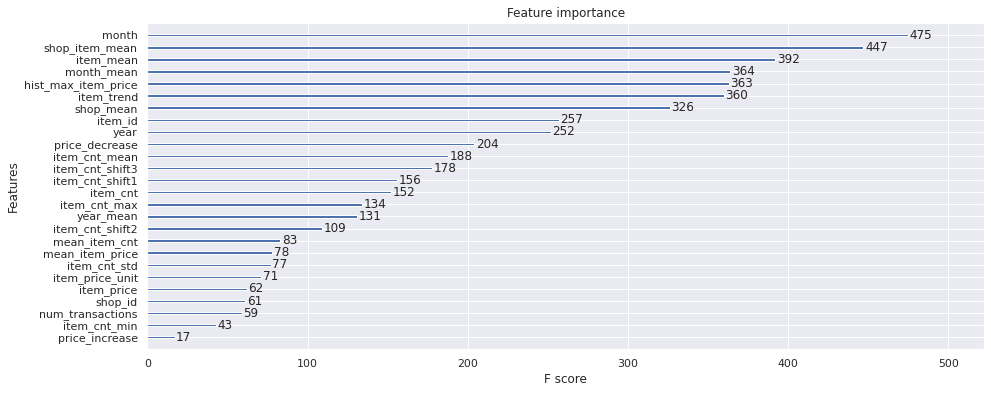

In [ ]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [ ]:
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_valid)
xgb_test_pred = xgb_model.predict(X_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, xgb_val_pred)))

Train rmse: 0.6420424935450978
Validation rmse: 0.778334144601914


### Random Forest

In [ ]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [ ]:
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_valid)
rf_test_pred = rf_model.predict(X_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, rf_val_pred)))

Train rmse: 0.6438789358333353
Validation rmse: 0.8171586101329176


### KNN REGRESSOR

In [ ]:
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shift1',
                'item_cnt_shift2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
y_train_sampled = y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_valid[knn_features]
knn_test = X_test[knn_features]

In [ ]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, y_train_sampled)

KNeighborsRegressor(leaf_size=13, n_jobs=-1, n_neighbors=9)

In [ ]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, knn_val_pred)))

Train rmse: 0.4608785223306452
Validation rmse: 0.7850377099307275


### CATBOOST

In [ ]:
cat_features = [0, 1, 7, 8]

#error with integer32
X_train[int_features] = X_train[int_features].astype('str')
X_valid[int_features] = X_valid[int_features].astype('str')
X_test[int_features] = X_test[int_features].astype('str')

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid)
)

Learning rate set to 0.297301
0:	learn: 0.8016715	test: 0.8462282	best: 0.8462282 (0)	total: 1.75s	remaining: 14m 33s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.7826231851
bestIteration = 14

Shrink model to first 15 iterations.


In [ ]:
print('Model params:', catboost_model.get_params())

Model params: {'iterations': 500, 'depth': 4, 'loss_function': 'RMSE', 'od_wait': 25, 'od_type': 'Iter', 'random_seed': 0, 'verbose': 50, 'max_ctr_complexity': 4}


In [ ]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_valid)
catboost_test_pred = catboost_model.predict(X_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, catboost_val_pred)))

Train rmse: 0.6507577651238173
Validation rmse: 0.7826231850569586


In [ ]:
# Feature importance code:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

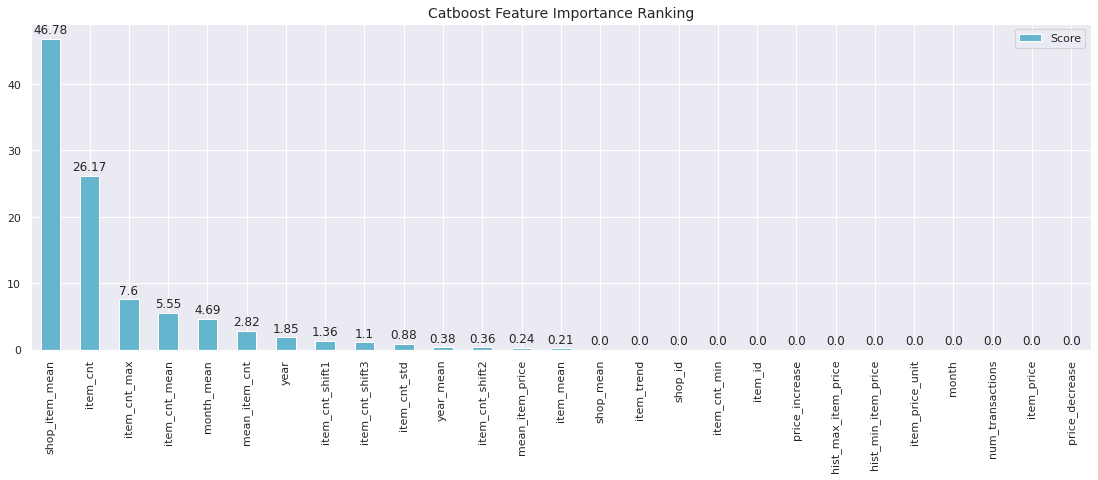

In [ ]:
plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

##### Meta-Model
We are using the first level models output to train the meta model, which consist on a simple linear regression algorithm.

In [ ]:
# Dataset that will be the train set of the ensemble model. Outputs from validation in first level model.
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = y_valid.values

In [ ]:
first_level.head()

,catboost,xgbm,random_forest,knn,label
0,0.53,0.56,0.54,0.44,1
1,0.78,0.47,0.89,1.00,0
2,0.03,0.20,0.12,0.11,2
3,3.29,2.15,2.79,2.33,0
4,1.49,1.03,1.39,0.67,0


In [ ]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,catboost,xgbm,random_forest,knn
0,0.38,0.56,0.62,1.00
1,0.01,0.06,0.00,0.00
2,0.78,0.47,0.58,0.67
3,0.13,0.07,0.00,0.00
4,0.01,0.06,0.00,0.00


In [ ]:
meta_model = LinearRegression(n_jobs=-1)

In [ ]:
# Trained on validation set using the 1st level models predictions as features.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, y_valid)

LinearRegression(n_jobs=-1)

In [ ]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)


In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, y_valid)))

Train rmse: 0.7581353785260646


In [ ]:
# Output
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.59
1,1,0.08
2,2,0.65
3,3,0.16
4,4,0.08
5,5,0.36
6,6,0.84
7,7,0.29
8,8,1.54
9,9,0.14


In [ ]:
# Output Best Model
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = rf_test_pred.clip(0., 20.)
prediction_df.to_csv('submission_tree.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.62
1,1,0.00
2,2,0.58
3,3,0.00
4,4,0.00
5,5,0.65
6,6,0.20
7,7,0.33
8,8,1.88
9,9,0.00


## REFRENCES

- https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775
- https://www.kaggle.com/code/dimitreoliveira/model-stacking-feature-engineering-and-eda